# Datasets and DataLoaders

# Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
%matplotlib inline

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torchvision.io import read_image

# Introduction

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: ``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset`` that allow us to use pre-loaded datasets as well as our own data.


``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around the ``Dataset`` to enable easy access to the samples.


PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that 
subclass ``torch.utils.data.Dataset`` and implement functions specific to the particular data.
They can be used to prototype and benchmark oour model. We can find them here: 
* [`Image Datasets`](https://pytorch.org/vision/stable/datasets.html)
* [`Text Datasets`](https://pytorch.org/text/stable/index.html)
* [`Audio Datasets`](https://pytorch.org/audio/stable/index.html)

# Datasets

## Loading a Dataset

Here is an example of how to load the [`Fashion-MNIST dataset`](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist) from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

We load the [`FashionMNIST Dataset`](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) with the following parameters:
 - ``root`` is the path where the train/test data is stored,
 - ``train`` specifies training or test dataset,
 - ``download=True`` downloads the data from the internet if it's not available at ``root``.
 - ``transform`` and ``target_transform`` specify the feature and label transformations



In [2]:
dataset_path = os.path.normpath(r'E:\Sync_With_NAS_Ext\Datasets\Image_Datasets\Pytorch_Datasets')

In [3]:
training_data = datasets.FashionMNIST(root = dataset_path, train = True, download = True,\
                                      transform = ToTensor())

test_data = datasets.FashionMNIST(root = dataset_path, train = False, download = True,\
                                  transform = ToTensor())

print(f"Type of training_data is {type(training_data)}")
print(f"Type of test_data is {type(test_data)}")
print()
print(training_data)
print()
print(test_data)

Type of training_data is <class 'torchvision.datasets.mnist.FashionMNIST'>
Type of test_data is <class 'torchvision.datasets.mnist.FashionMNIST'>

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: E:\Sync_With_NAS_Ext\Datasets\Image_Datasets\Pytorch_Datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: E:\Sync_With_NAS_Ext\Datasets\Image_Datasets\Pytorch_Datasets
    Split: Test
    StandardTransform
Transform: ToTensor()


In [4]:
print(f"Number of samples in training_data is {len(training_data)}")
print(f"Number of samples in test_data is {len(test_data)}")

Number of samples in training_data is 60000
Number of samples in test_data is 10000


## Iterating and Visualizing the Dataset

We can index ``Datasets`` manually like a list: ``training_data[index]``. 

In [5]:
ind = 0 # First entry in training_data
print(f"Type of training_data is {type(training_data[0])}")
print(f"Length of first entry of training_data is {len(training_data[0])}")
print(f"Type of first element of tuple is {type(training_data[0][0])}")
print(f"Type of second element of tuple is {type(training_data[0][1])}")
print()
print(f"Shape of first element of tuple is {training_data[0][0].shape}")
print(f"Value of second element of tuple is {training_data[0][1]}")

Type of training_data is <class 'tuple'>
Length of first entry of training_data is 2
Type of first element of tuple is <class 'torch.Tensor'>
Type of second element of tuple is <class 'int'>

Shape of first element of tuple is torch.Size([1, 28, 28])
Value of second element of tuple is 9


## Get mapping from classes to class labels

In [6]:
# Dictionary to map classes to class labels
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

display(labels_map)

{0: 'T-Shirt',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle Boot'}

## Plot some random samples along with labels

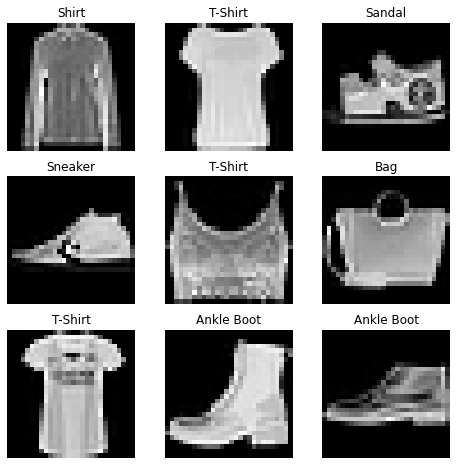

In [7]:
# Plot nine random samples from training set
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3 # 3 x 3 grid for plotting images
for i in range(1, cols * rows + 1): # Iterate from 1 to 9
    # Generate a random sample index from training_data
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    # Extract image and label from training_data corresponding to sample_idx
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap = "gray")
plt.show()

## Creating a Custom Dataset

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. 

Consider the following implementation where the images are stored in a directory ``img_dir``, and their labels are stored separately in a CSV file ``annotations_file``. 

The annotations_file (labels.csv) looks like this:

    * tshirt1.jpg, 0
    * tshirt2.jpg, 0
    * ......
    * ankleboot999.jpg, 9

### Define CustomImageDataset class

In [8]:
class CustomImageDataset(Dataset): # Custom Dataset class subclassing Dataset class
    
    def __init__(self, annotations_file, img_dir, transform = None, target_transform = None):
        # self.img_labels -> Pandas dataframe containing labels from annotations_file
        self.img_labels = pd.read_csv(annotations_file) 
        # self.img_dir -> Set to path img_dir containing image files
        self.img_dir = img_dir
        # self.transform -> Transform for images
        self.transform = transform
        # self.target_transform -> Transform for target labels
        self.target_transform = target_transform

    def __len__(self):
        # Returns the number of samples in the dataset
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Define path of image file at location idx
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # Read image from img_path
        image = read_image(img_path)
        # Read label at location idx
        label = self.img_labels.iloc[idx, 1]
        # Transform input image
        if self.transform:
            image = self.transform(image)
        # Transform label
        if self.target_transform:
            label = self.target_transform(label)
        # Create dictionary containing image and label
        sample = {"image": image, "label": label}
        
        return sample

# DataLoaders

## Preparing our data for training with DataLoaders

The ``Dataset`` retrieves our dataset's features and labels one sample at a time. While training a model, we typically want to 
pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's ``multiprocessing`` to
speed up data retrieval.

``DataLoader`` is an iterable that abstracts this complexity for us in an easy API.

In [9]:
train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)
print(f"Type of train_dataloader is {type(train_dataloader)}")
print(f"Type of test_dataloader is {type(test_dataloader)}")

Type of train_dataloader is <class 'torch.utils.data.dataloader.DataLoader'>
Type of test_dataloader is <class 'torch.utils.data.dataloader.DataLoader'>


## Iterate through the DataLoader

We have loaded the dataset into the ``Dataloader`` and can iterate through the dataset as needed.
Each iteration below returns a batch of ``train_features`` and ``train_labels``(containing ``batch_size=64`` features and labels respectively).


Because we specified ``shuffle=True``, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at [`Samplers`](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


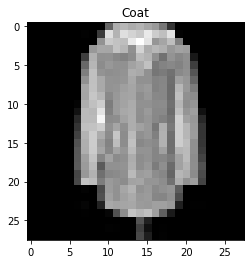

In [10]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap = "gray")
plt.title(labels_map[label.item()])
plt.show()

# Further Reading

- [`torch.utils.data API`](https://pytorch.org/docs/stable/data.html)